# Modelo de n-gramas para determinar la polaridad del texto

PLN - MCD - UNISON

Alumnos:

Estephania Pivac Alcaraz

José Carlos Maldonado Barreras

## Estrategia

1. Elegir el modelo de n-gramas.

2. Crear un grupo de entrenamiento (85%) y otro de prueba (15%).

**Conjunto de entrenamiento:**

3. Dentro del grupo de entrenamiento, crear dos subgrupos; el primero con las opiniones positivas y el segundo con las opiniones negativas.

4. Obtener los n-gramas de cada subgrupo.

5. En una estructura tipo diccionario, a cada n-grama se le asigna un número entero que representa la cantidad de veces que dicho n-grama apareció en el subgrupo y el respectivo subgrupo al que pertenece.

6. Con los n-gramas que están presentes en ambos subgrupos, se tendrá que restar sus respectivos valores asociados y el resultado será el valor asociado final de dicho n-grama.

**Conjunto de prueba:**

7. Para que el modelo asigne la polaridad a un texto del conjunto prueba, primero tendrá que obtener los n-gramas de dicho texto.

8. A cada n-grama le asignará su valor asociado en el conjunto de entrenamiento.

9. Se calculará opcionalmente, el valor de entropía asociado a cada n-grama para identificar aquellos n-gramas que resulten relevantes para la tarea de clasificación de acuerdo a un umbral.

10. Se realizará la suma de todos los valores asociados a los n-gramas del texto y el signo del resultado determinará la polaridad de dicho texto.

11. Evaluar desempeño del modelo con F1-score.

In [1]:
# Importar las librerías necesarias
import pandas as pd
import re
import math
import string
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

# Descargar los recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Función para cargar y preparar los datos

**Con esta función:**

1. Se cargan los datos desde un archivo CSV
2. Se concatenan los strings que se encuentran en la columna "Opinion" y en la columna "Title"
3. Se eliminan las filas que contienen nan's
4. Se separan los datos en un conjunto de entrenamiento (85%) y uno de prueba (15%)

In [2]:
# Función para cargar y preparar los datos
def load_and_prepare_data(file_path, test_size=0.15):
    """
    Carga el contenido de un archivo CSV y lo divide en conjuntos de prueba y entrenamiento.

    file_path: Ruta al archivo CSV

    return: Un DataFrame con los datos de entrenamiento y otro con los datos de prueba.
    """
    df = pd.read_csv(file_path)                                   # Cargar CSV
    df['Text'] = df['Title'] + " " + df['Opinion']                # Concatenar opinión y título
    df = df.dropna()                                              # Eliminar filas con nan's

    return train_test_split(df, test_size=test_size, random_state=42)  # Divir datos en conjuntos de entrenamiento y prueba

### Función para limpiar el texto

**Con esta función:**

1. De manera opcional, se pueden eliminar los signos de puntuación.
2. De manera opcional,

    2.1. Todo el texto se pasa a mínusculas

    2.2. Se realiza una tokenización del texto
    
    2.3  Se une el texto separando los tokens por espacios, ignorando las stopwords.
    
3. De manera opcional, se lematiza el texto.

In [3]:
# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def clean_text(text, remove_punctuation=True, remove_stopwords=True, lemmatize=True):
    """
    Limpia un texto (string) eliminando signos de puntuación, stopwords y/o lematizando.

    text: Texto en formato string
    remove_punctuation: Booleano que determina si se eliminan o no los signos de puntuación
    remove_stopwords: Booleano que determina si se eliminan o no las stopwords
    lemmatize: Booleano que determina si se lematiza o no el texto

    return: Texto (string) limpio.
    """
    # Asegurarse de que 'text' es una cadena
    text = str(text)

    if remove_punctuation:
        # Definimos los signos de puntuación que queremos eliminar
        punctuation = re.escape(string.punctuation) + '¡' + ',' + ';'
        # Usa una expresión regular para eliminar los signos de puntuación
        text = re.sub(f'[{punctuation}]', '', text)  # Eliminar signos de puntuación

    if remove_stopwords:
        stop_words = set(stopwords.words('spanish'))  # Extraer stopwords
        text = ' '.join([word for word in word_tokenize(text.lower()) if word not in stop_words])  # Tokenizar y filtrar stopwords

    if lemmatize:
        text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text.lower())])  # Lematizar cada palabra

    return text


### Función para obtener los k-skip-n-gramas

**Con esta función:**

1. Se realiza una tokenización del texto.
2. Se obtienen los k-skip-n-gramas del texto, con una k y n establecidas por el usuario.

In [4]:
# Función para obtener n-gramas
def get_ngrams(text, n=2, skip=0):
    """
    Genera n-gramas (o skip-gramas si skip > 0) a partir de un texto.

    text: Texto a partir del cual se extraerán los n-gramas (o skip-gramas)
    n: Número de palabras en el n-grama
    skip: Número de palabras a saltar (solo para skip-gramas)

    return: Lista de n-gramas
    """
    tokens = word_tokenize(text)  # Tokenizar el texto todo en mínusculas

    # Obterner n-gramas
    if skip == 0:
        return list(ngrams(tokens, n))

    # Obtener k-skip-n-gramas
    else:
        return list(nltk.skipgrams(tokens, n, skip))

### Función para obtener la frecuencia de aparición de n-gramas en un corpus

**Con esta función:**

1. Se obtienen los n-gramas de todos los textos de un corpus dado utilizando *get_ngrams*.
2. Se cuenta la cantidad de veces que aparece cada n-grama en el corpus.
3. Cada vez que un n-grama aparece en el corpus a su frecuencia de aparición se le suma el valor "weight" pre-determinado por el usuario.

In [5]:
# Función para calcular las frecuencias de los n-gramas
def calculate_ngram_frequencies(texts, n=2, skip=0, weight=1):
    """
    Genera n-gramas (o skip-gramas si skip > 0) a partir de un conjunto de textos y calcula su frecuencia de aparición con base en weight.

    texts: Conjunto de textos de los que se obtendrán los n-gramas (o skip-gramas)
    n: Número de palabras en el n-grama
    skip: Número de palabras a saltar (solo para skip-gramas)
    weight: Cada aparición de un n-grama dado contribuirá con un valor de weight a su frecuencias

    return: defaultdict con la frecuencia de aparición de cada n-grama.
    """

    ngram_values = defaultdict(int)  # Definir un defaultdict vacío

    # Iterar sobre todos los textos
    for text in texts:
        ngrams = get_ngrams(text, n, skip)  # Obtener n-gramas (o skip-gramas)

        # Iterar sobre todos los n-gramas
        for ngram in ngrams:
            ngram_values[ngram] += weight  # Sumar el valor weight a la frecuencia de cada n-grama cada vez que aparezca

    return ngram_values

### Función para calcular la entropía de un n-grama basado en las frecuencias de ocurrencia en las dos categorías (positivo y negativo).

La entropía mide la incertidumbre o el desorden en la distribución de probabilidad de un evento. En este caso, se utiliza para medir la cantidad de información o incertidumbre asociada con el n-grama en cuestión.

In [6]:
def entropy_for_ngram(pos_freq, neg_freq):
    """Calcula la entropía de un n-grama."""
    total_freq = pos_freq + neg_freq
    if total_freq == 0:
        return 0

    p_pos = pos_freq / total_freq if pos_freq > 0 else 0
    p_neg = neg_freq / total_freq if neg_freq > 0 else 0

    entropy = 0
    if p_pos > 0:
        entropy -= p_pos * math.log2(p_pos)
    if p_neg > 0:
        entropy -= p_neg * math.log2(p_neg)

    return entropy


### Función para realizar el cálculo de la frecuencia de aparición de cada n-grama utilizando un valor de weight específico

**Con esta función:**

1. Se utiliza *calculate_ngram_frequencies*  para ajustar el valor de weight, aplicando el hecho de que los n-gramas apareciendo en textos negativos reciben un valor de weight negativo y los n-gramas apareciendo en textos positivos reciben un valor positivo.
2. Además, dado el desbalance de las clases (solo el 5% son textos negativos), de manera opcional puede aplicarse un weight como sigue:

    weight= 1/len(textos_positivos) para los n-gramas apareciendo en textos positivos
    
    weight= -1/len(textos_negativos) para los n-gramas apareciendo en textos negativos

3. Opcionalmente, se utiliza la función de entropía con un umbral seleccionado por el ususario (predeterminado en 0.5) para seleccionar solo los n-gramas relevantes para la tarea de clasificación.

4. Independientemente de los valores de weight utilizados, se suman las frecuencias de aparición de los n-gramas en el grupo positivo y negativo, dando como resultado una frecuencia neta para cada n-grama.


In [7]:
def apply_class_weighting(positive_texts, negative_texts, n=2, skip=0, apply_weighting=True, use_entropy=True, entropy_threshold=0.5):
    """
    Realiza una reponderación de la frecuencia de aparición de cada n-grama dependiendo del grupo al que pertenece
    y opcionalmente aplica un filtro de entropía para eliminar n-gramas ambiguos.

    positive_texts: Textos calificados como positivos (Label = 1)
    negative_texts: Textos calificados como negativos (Label = 0)
    n: Número de palabras en el n-grama
    skip: Número de palabras a saltar (solo para skip-gramas)
    apply_weighting: Booleano que determina si se desea ponderar las frecuencias de aparición de los n-gramas
    use_entropy: Booleano que determina si se utiliza la entropía para filtrar los n-gramas
    entropy_threshold: Umbral de entropía para eliminar n-gramas ambiguos

    return: defaultdict con la frecuencia de aparición reponderada de los n-gramas
    """

    num_positive = len(positive_texts)  # Cantidad de textos clasificados como positivos
    num_negative = len(negative_texts)  # Cantidad de textos clasificados como negativos

    # Peso que tendrá la aparición de un n-grama en cada grupo
    weight_positive = 1 / num_positive if apply_weighting and num_positive > 0 else 1
    weight_negative = 1 / num_negative if apply_weighting and num_negative > 0 else 1

    # Calcular frecuencias de aparición en los grupos positivo y negativo con sus respectivos pesos
    positive_ngram_values = calculate_ngram_frequencies(positive_texts, n, skip, weight_positive)
    negative_ngram_values = calculate_ngram_frequencies(negative_texts, n, skip, weight_negative)

    combined_ngram_values = defaultdict(lambda: {"freq": 0, "sentiment": ""})

    for ngram in set(positive_ngram_values.keys()).union(set(negative_ngram_values.keys())):
        pos_freq = positive_ngram_values.get(ngram, 0)
        neg_freq = negative_ngram_values.get(ngram, 0)

        # Calcular la entropía y decidir si aplicar el filtro
        if use_entropy:
            entropy_value = entropy_for_ngram(pos_freq, neg_freq)
            if entropy_value >= entropy_threshold:
                continue  # Si la entropía es mayor que el umbral, saltamos este n-grama

        # Sumar las frecuencias ponderadas
        combined_freq = pos_freq + neg_freq

        # Asignar sentimiento dominante
        sentiment = 1 if pos_freq > abs(neg_freq) else 0

        combined_ngram_values[ngram]["freq"] = combined_freq
        combined_ngram_values[ngram]["sentiment"] = sentiment

    return combined_ngram_values


### Función para predecir la polaridad de un texto

**Con esta función:**

1. Se obtienen los n-gramas de un texto con *get_ngrams*
2. Cada n-grama se asocia con su valor de frecuencia neta calculado a partir de un weight y de su frecuencia de aparición en el grupo positivo y negativo
3. Se suman las frecuencias netas de los n-gramas que componen al texto para obtener la polaridad del texto:

    Si el signo del output es negativo, entonces es un texto negativo

    Si el signo del output es positivo, entonces es un texto positivo


In [8]:
def predict_polarity_for_df(df, ngram_analysis, n=2, skip=0):
    """
    Predice la polaridad de cada texto en un dataframe basado en n-gramas útiles (con baja entropía).

    df: DataFrame que contiene la columna 'Text'.
    ngram_analysis: Diccionario de n-gramas útiles con sus frecuencias relativas y sentimiento.
    n: Número de palabras en el n-grama.
    skip: Número de palabras a saltar (solo para skip-gramas).

    return: DataFrame con una nueva columna 'Polarity' que contiene la polaridad predicha para cada fila.
    """
    polarities = []

    for text in df['Text']:
        # Calcular los n-gramas del texto
        ngrams_in_text = get_ngrams(text, n, skip)

        # Contar los puntos positivos y negativos
        score = 0

        for ngram in ngrams_in_text:
            if ngram in ngram_analysis:
                sentiment = ngram_analysis[ngram]["sentiment"]
                relative_freq = ngram_analysis[ngram]["freq"]

                # Asignar puntuación según el sentimiento del n-grama
                if sentiment == 1:
                    score += relative_freq
                elif sentiment == 0:
                    score -= relative_freq

        # Decidir la polaridad basada en la puntuación final
        if score > 0:
            polarity = 1
        elif score < 0:
            polarity = 0
        else:
            polarity = 1

        polarities.append(polarity)

    # Añadir la columna 'Polarity' al dataframe
    df['Polarity'] = polarities
    return df



### Función para realizar todo un experimento con un modelo de n-grama dado

**Con esta función:**

1. Se cargan y preparan los datos *load_and_prepare_data*, generando un corpus de entrenamiento y uno de prueba
2. De manera opcional, se remueven los signos de puntuación de los textos con *clean_data*
3. De manera opcional, se remueven las stopwords de los textos con *clean_data*
4. De manera opcional, se lematiza el texto.
5. De manera opcional, se realiza un análisis de los n-gramas a partir de la función de entropía.
6. Con los textos de entrenamiento, se obtienen las frecuencias neta de los k-skip-n-gramas (con k y n determinados por el usuario) con base en su frecuencia de aparición en los textos positivos y negativos utilizando *apply_class_weighting*

7. De manera opcional, se puede utilizar los valores de weight para abordar el problema del desbalance de clases

8. Con cada texto de prueba, se suman las frecuencias netas de sus k-skip-n-gramas y se predice su polaridad
9. Se mide el desempeño del modelo por medio de la F1-score y el F1-weighted

In [9]:
# Función principal para entrenar y evaluar el modelo
def run_experiment(file_path, n=2, skip=0, remove_punctuation=True, remove_stopwords=True, apply_weighting=True, lemmatize = True, use_entropy = True):
    """
    Hace uso de las funciones definidas anteriormente para evaluar el desempeño de un modelo de n-gramas prediciendo la polaridad del conjunto de textos de prueba.

    file_path: Ruta al archivo CSV con los datos
    n: Número de palabras en el n-grama
    skip: Número de palabras a saltar (solo para skip-gramas)
    remove_punctuation: Booleano que determina si se elimina o no los signos de puntuación
    remove_stopword: Booleano que determina si se elimina o no las stopwords
    apply_weighting: Booleano que determina si se desea ponderar las frecuencias de aparición de los n-gramas con base en el desbalance de clases

    return: 1 si la polaridad del texto es positiva y -1 si la polaridad es negativa
    """

    # Cargar datos de entrenamiento y prueba
    train_data, test_data = load_and_prepare_data(file_path)

    # Limpiar datos (eliminar signos de puntuación y stopwords)
    train_data['Text'] = train_data['Text'].apply(lambda x: clean_text(x, remove_punctuation, remove_stopwords, lemmatize))
    test_data['Text'] = test_data['Text'].apply(lambda x: clean_text(x, remove_punctuation, remove_stopwords, lemmatize))

    # Separar textos positivos y negativos
    positive_texts = train_data[train_data['Label'] == 1]['Text']
    negative_texts = train_data[train_data['Label'] == 0]['Text']


    # Obtener las frecuencias netas de los n-gramas en el corpus
    ngram_values = apply_class_weighting(positive_texts, negative_texts, n, skip, apply_weighting, use_entropy)
    # Predecir la polaridad de los textos
    y_pred = predict_polarity_for_df(test_data, ngram_values, n, skip)

    # Evaluar el desempeño del modelo con f1-score
    return f1_score(y_pred['Label'], y_pred['Polarity']), f1_score(y_pred['Label'], y_pred['Polarity'], average='weighted')

### Función para realizar un Grid Search sobre los parámetros de la función *run_experiment*

**Con esta función:**

1. Se ejecuta *run_experiment* con todas las combinaciones de valores posibles para sus parámetros
2. En cada caso se cálcula el valor de F1-score
3. Se guarda el valor más alto de F1-score y sus los valores respectivos de los parámetros de *run_experiment*

In [14]:
import itertools
import pandas as pd
import math

def grid_search(file_path):
    """
    Realizar un grid search sobre los parámetros de la función run_experiment.
    Imprime el F1-score y los valores de los parámetros de run_experiment asociados.

    file_path: Ruta al archivo CSV con los datos

    return: None
    """
    # Posibles valores de los n-gramas (nos limitamos a uni, bi y trigramas)
    n_values = [1, 2, 3]
    # Posibles valores de k en k-skip-n-gramas (nos limitamos a saltos de 1 y 2 tokens)
    skip_values = [0, 1, 2]
    # Posibles valores de los parámetros booleanos
    remove_punctuation_options = [True, False]
    remove_stopwords_options = [True, False]
    lemmatize_options = [True, False]
    apply_weighting_options = [True, False]
    apply_entropy_options = [True, False]

    # Generar todas las combinaciones posibles de parámetros
    param_grid = itertools.product(
        n_values,
        skip_values,
        remove_punctuation_options,
        remove_stopwords_options,
        lemmatize_options,
        apply_entropy_options,
        apply_weighting_options
    )

    # Lista para almacenar los resultados
    results = []

    for params in param_grid:
        n, skip, remove_punctuation, remove_stopwords, lemmatize, use_entropy, apply_weighting = params

        # Omitimos los casos en los que n==1 y skip > 0
        if n == 1 and skip > 0:
            continue

        # Ejecutamos run_experiment con un set de valores en sus parámetros
        f1, f1_weighted = run_experiment(
            file_path,
            n=n,
            skip=skip,
            remove_punctuation=remove_punctuation,
            remove_stopwords=remove_stopwords,
            lemmatize=lemmatize,
            use_entropy=use_entropy,
            apply_weighting=apply_weighting
        )

        # Guardar los resultados
        results.append({
            'F1-score': f1,
            'F1-score-weighted': f1_weighted,
            'n': n,
            'skip': skip,
            'remove_punctuation': remove_punctuation,
            'remove_stopwords': remove_stopwords,
            'lemmatize': lemmatize,
            'use_entropy': use_entropy,
            'apply_weighting': apply_weighting
        })

        print(f"F1-score: {f1:.4f}  F1-score-weighted: {f1_weighted:.4f} | Params: n={n}, skip={skip}, remove_punctuation={remove_punctuation}, remove_stopwords={remove_stopwords}, lemmatize={lemmatize}, apply_weighting={apply_weighting}, use_entropy={use_entropy}")

    # Convertir los resultados a un DataFrame
    df_results = pd.DataFrame(results)

    # Encontrar el mejor resultado
    best_result = df_results.loc[df_results['F1-score'].idxmax()]

    print("\nBest F1-score:", best_result['F1-score'])
    print("Best F1-score-weighted:", best_result['F1-score-weighted'])
    print("Best Parameters:", best_result.drop(['F1-score', 'F1-score-weighted']).to_dict())



In [36]:
file_path = './Datos/train.csv'

In [16]:
# Ejecutar el Grid Search
grid_search(file_path)

F1-score: 0.8872  F1-score-weighted: 0.8160 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=True, apply_weighting=True, use_entropy=True
F1-score: 0.9044  F1-score-weighted: 0.7654 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=True, apply_weighting=False, use_entropy=True
F1-score: 0.8076  F1-score-weighted: 0.7353 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=True, apply_weighting=True, use_entropy=False
F1-score: 0.8987  F1-score-weighted: 0.7333 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=True, apply_weighting=False, use_entropy=False
F1-score: 0.8872  F1-score-weighted: 0.8160 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=False, apply_weighting=True, use_entropy=True
F1-score: 0.9028  F1-score-weighted: 0.7590 | Params: n=1, skip=0, remove_punctuation=True, remove_stopwords=True, lemmatize=False, apply_weighti

### A partir del Grid Search se identificó que el mejor modelo es un **2-skip-3-grama** actuando sobre textos **con signos de puntuación**, **con stopwords**, **sin lematizar**, **utilizando la entropía** y **con weights relativos para las clases** para los n-gramas apareciendo en textos positivos y negativos, respectivamente.

Definimos una función para obtener las otras métricas (matriz de confusión, accuracy, recall y precision) de un modelo específico y con los datos siendo sometidos a un preprocesamiento determinado

In [28]:
# Función para evaluar el modelo bajo otras métricas
def evaluate_model(file_path, n, skip, remove_punctuation, remove_stopwords, lemmatize, use_entropy, apply_weighting, entropy_threshold=0.5):
    # Cargar y preparar los datos
    train_data, test_data = load_and_prepare_data(file_path)
    train_data['Text'] = train_data['Text'].apply(lambda x: clean_text(x, remove_punctuation=remove_punctuation, remove_stopwords=remove_stopwords, lemmatize=lemmatize))
    test_data['Text'] = test_data['Text'].apply(lambda x: clean_text(x, remove_punctuation=remove_punctuation, remove_stopwords=remove_stopwords, lemmatize=lemmatize))

    # Crear subgrupos de entrenamiento: positivos (Label=1) y negativos (Label=0)
    positive_texts = train_data[train_data['Label'] == 1]['Text']
    negative_texts = train_data[train_data['Label'] == 0]['Text']


    # Obtener las frecuencias netas de los n-gramas en el corpus
    ngram_values = apply_class_weighting(positive_texts, negative_texts, n, skip, apply_weighting=apply_weighting, use_entropy=use_entropy, entropy_threshold=entropy_threshold)

    # Predecir la polaridad de los textos en el conjunto de prueba
    y_pred = predict_polarity_for_df(test_data, ngram_values, n=n, skip=skip)

    # Evaluar el modelo
    y_test = test_data['Label']

    # Mostrar las métricas
    print(f"Accuracy: {accuracy_score(y_test, y_pred['Polarity']):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred['Polarity']):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred['Polarity']):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred['Polarity']):.4f}")
    print(f"F1-weighted-score: {f1_score(y_test, y_pred['Polarity'], average='weighted'):.4f}")
    print("\n \n")
    cm = confusion_matrix(y_test, y_pred['Polarity'])

    # Crea la figura
    plt.figure(figsize=(6, 4))

    # Usa seaborn para crear un mapa de calor de la matriz de confusión con una paleta de colores diferente
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=['Clase 0', 'Clase 1'],  # Etiquetas de las clases en el eje X
                yticklabels=['Clase 0', 'Clase 1'],  # Etiquetas de las clases en el eje Y
                cbar=True,  # Añade una barra de color
                cbar_kws={'label': 'Frecuencia'})  # Etiqueta para la barra de color

    # Añade títulos y etiquetas
    plt.title('Matriz de Confusión', fontsize=14)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.ylabel('Etiqueta Verdadera', fontsize=12)

    # Muestra la gráfica
    plt.show()

## Mejor configuración

- 2-skip-3-grama
- con signos de puntuación
- con stopwords
- sin lematizar
- utilizando la entropía
- con weights relativos para las clases

Accuracy: 0.8627
Precision: 0.9182
Recall: 0.9131
F1-score: 0.9157
F1-weighted-score: 0.8634

 



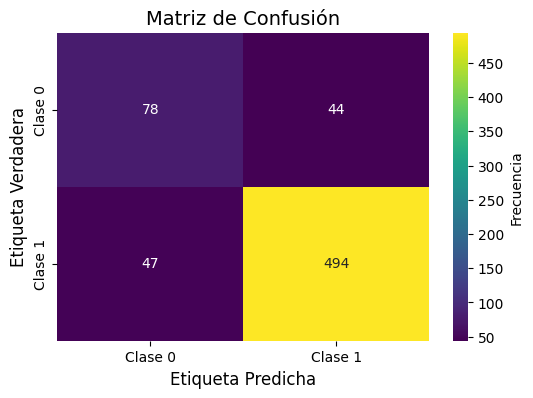

In [29]:
# Ejecutar la evaluación del modelo
evaluate_model(file_path, n= 3, skip= 2, remove_punctuation= False, remove_stopwords= False, lemmatize= False, use_entropy= True, apply_weighting= True)

## Comparación de diferentes entropy threshold

In [51]:
import pandas as pd

def evaluate_with_entropy_thresholds(file_path):
    """
    Ejecuta la evaluación del modelo con diferentes valores de entropy_threshold desde 0 hasta 0.95 con un paso de 0.05.
    Imprime los resultados y devuelve un DataFrame con los resultados.

    file_path: Ruta al archivo CSV con los datos

    return: DataFrame con los resultados
    """
    # Valores de entropy_threshold a probar
    thresholds = [round(i * 0.05, 2) for i in range(19)]

    # Lista para almacenar los resultados
    results = []

    for threshold in thresholds:
        print(f'\n \n \nUmbral = {threshold}\n')
        # Ejecuta la evaluación del modelo con el valor actual de entropy_threshold
        evaluate_model(
            file_path,
            n=3,
            skip=2,
            remove_punctuation=False,
            remove_stopwords=False,
            lemmatize=False,
            use_entropy=True,
            apply_weighting=True,
            entropy_threshold=threshold
        )

    # Devuelve el DataFrame
    return



 
 
Umbral = 0.0

Accuracy: 0.8160
Precision: 0.8160
Recall: 1.0000
F1-score: 0.8987
F1-weighted-score: 0.7333

 



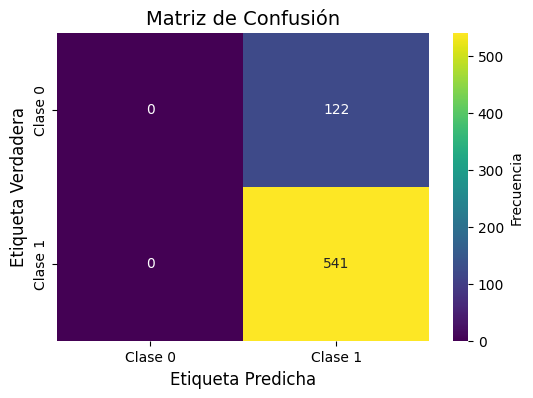


 
 
Umbral = 0.05

Accuracy: 0.8627
Precision: 0.8775
Recall: 0.9667
F1-score: 0.9200
F1-weighted-score: 0.8461

 



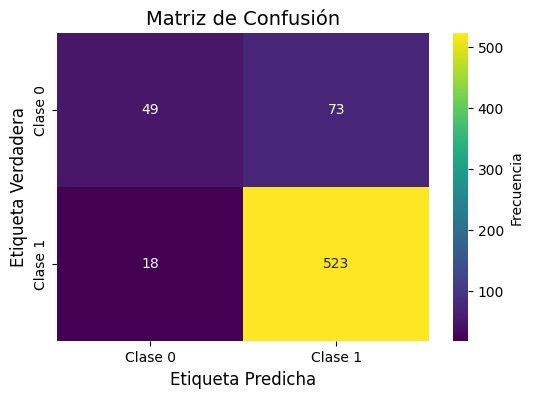


 
 
Umbral = 0.1

Accuracy: 0.8627
Precision: 0.8775
Recall: 0.9667
F1-score: 0.9200
F1-weighted-score: 0.8461

 



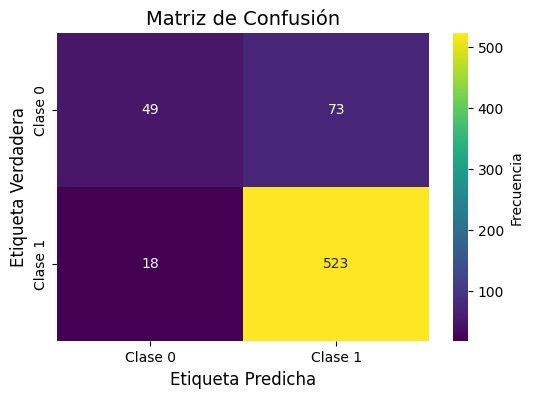


 
 
Umbral = 0.15

Accuracy: 0.8627
Precision: 0.8775
Recall: 0.9667
F1-score: 0.9200
F1-weighted-score: 0.8461

 



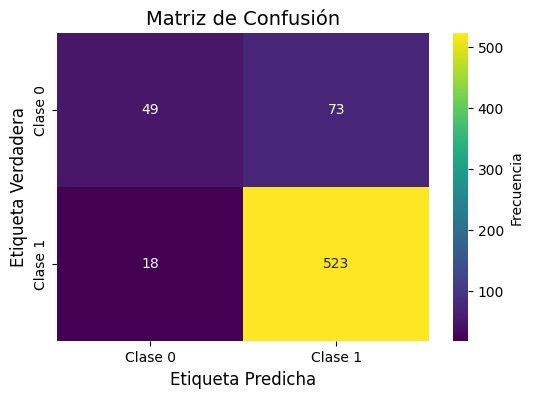


 
 
Umbral = 0.2

Accuracy: 0.8658
Precision: 0.8805
Recall: 0.9667
F1-score: 0.9216
F1-weighted-score: 0.8503

 



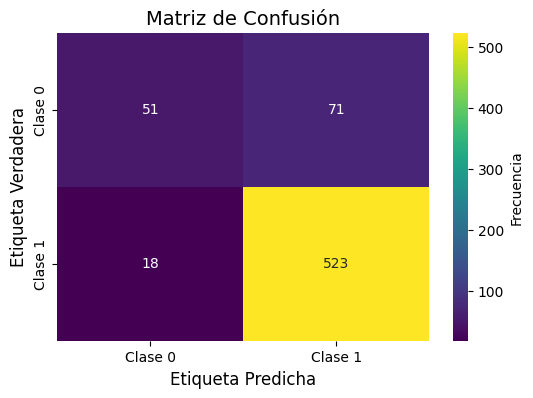


 
 
Umbral = 0.25

Accuracy: 0.8673
Precision: 0.8832
Recall: 0.9649
F1-score: 0.9223
F1-weighted-score: 0.8531

 



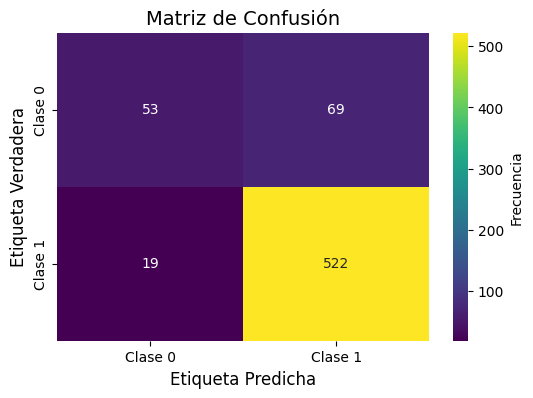


 
 
Umbral = 0.3

Accuracy: 0.8688
Precision: 0.8874
Recall: 0.9612
F1-score: 0.9228
F1-weighted-score: 0.8566

 



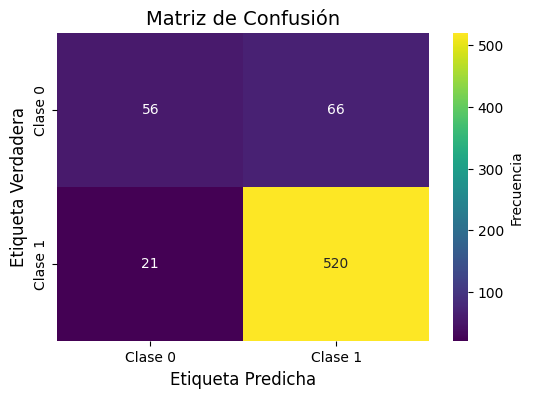


 
 
Umbral = 0.35

Accuracy: 0.8627
Precision: 0.8906
Recall: 0.9482
F1-score: 0.9185
F1-weighted-score: 0.8534

 



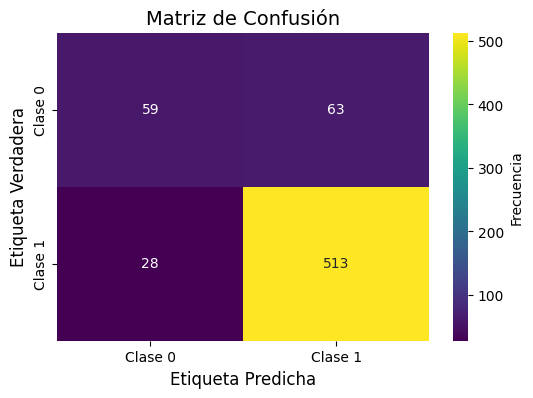


 
 
Umbral = 0.4

Accuracy: 0.8688
Precision: 0.8982
Recall: 0.9464
F1-score: 0.9217
F1-weighted-score: 0.8616

 



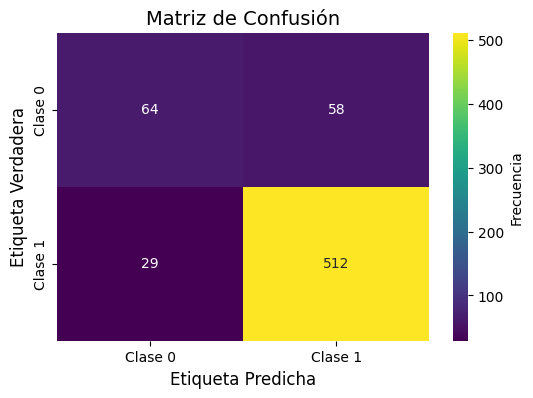


 
 
Umbral = 0.45

Accuracy: 0.8688
Precision: 0.8982
Recall: 0.9464
F1-score: 0.9217
F1-weighted-score: 0.8616

 



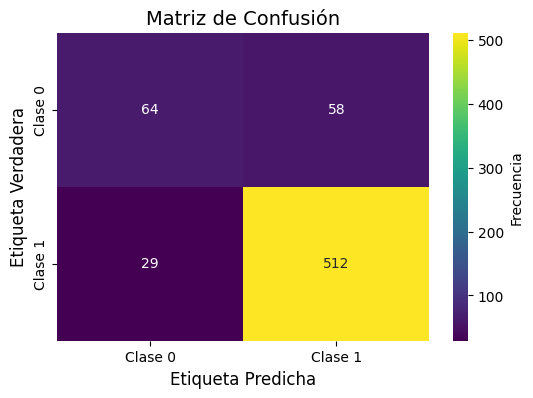


 
 
Umbral = 0.5

Accuracy: 0.8627
Precision: 0.9182
Recall: 0.9131
F1-score: 0.9157
F1-weighted-score: 0.8634

 



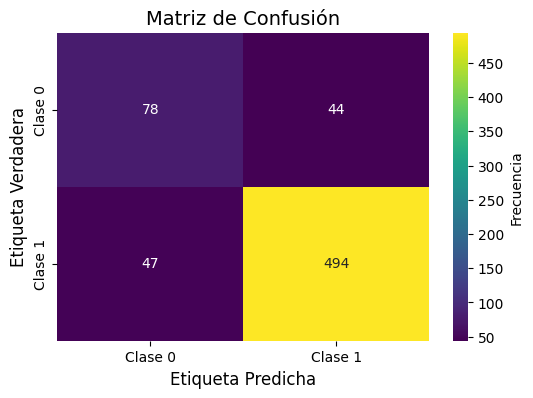


 
 
Umbral = 0.55

Accuracy: 0.8492
Precision: 0.9200
Recall: 0.8928
F1-score: 0.9062
F1-weighted-score: 0.8527

 



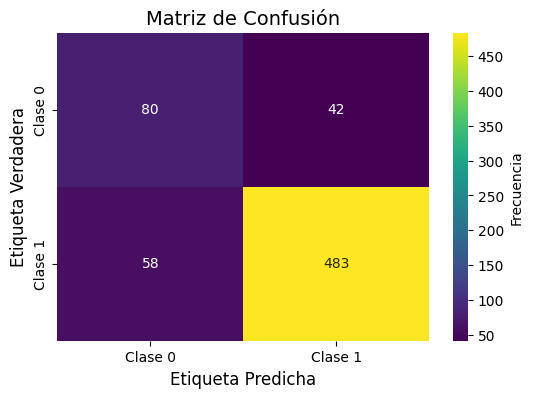


 
 
Umbral = 0.6

Accuracy: 0.8326
Precision: 0.9183
Recall: 0.8725
F1-score: 0.8948
F1-weighted-score: 0.8388

 



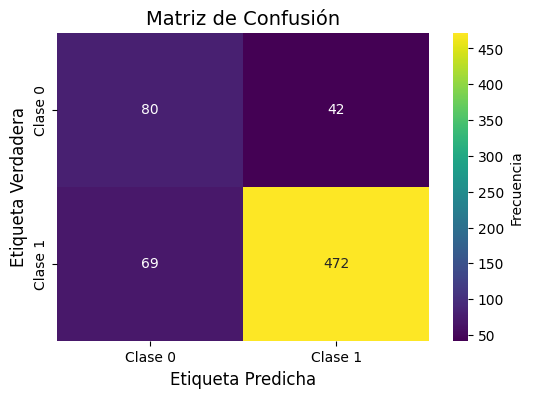


 
 
Umbral = 0.65

Accuracy: 0.8356
Precision: 0.9269
Recall: 0.8669
F1-score: 0.8959
F1-weighted-score: 0.8432

 



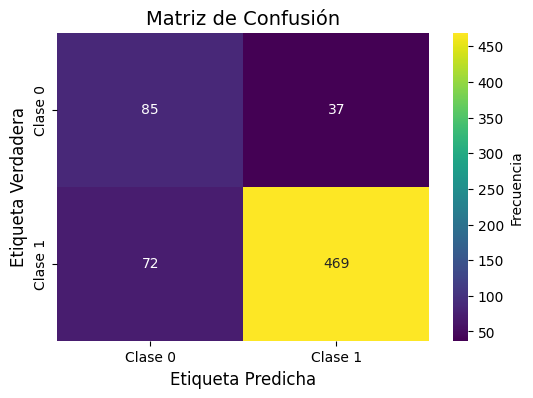


 
 
Umbral = 0.7

Accuracy: 0.7858
Precision: 0.9365
Recall: 0.7911
F1-score: 0.8577
F1-weighted-score: 0.8042

 



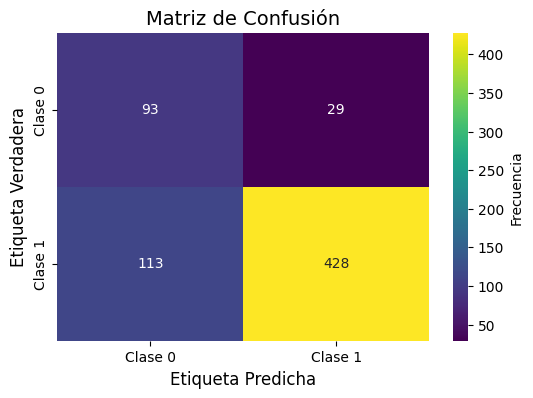


 
 
Umbral = 0.75

Accuracy: 0.7722
Precision: 0.9412
Recall: 0.7689
F1-score: 0.8464
F1-weighted-score: 0.7936

 



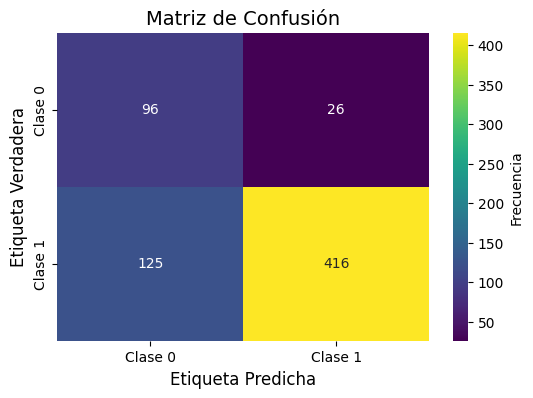


 
 
Umbral = 0.8

Accuracy: 0.7572
Precision: 0.9439
Recall: 0.7468
F1-score: 0.8338
F1-weighted-score: 0.7814

 



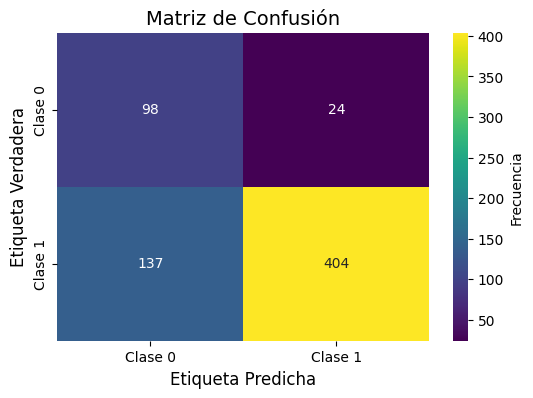


 
 
Umbral = 0.85

Accuracy: 0.7451
Precision: 0.9346
Recall: 0.7394
F1-score: 0.8256
F1-weighted-score: 0.7706

 



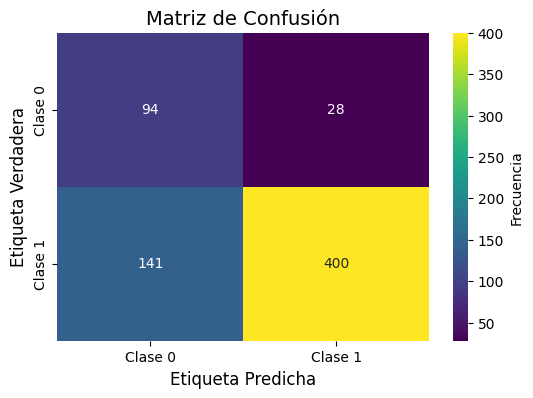


 
 
Umbral = 0.9

Accuracy: 0.7300
Precision: 0.9289
Recall: 0.7246
F1-score: 0.8141
F1-weighted-score: 0.7576

 



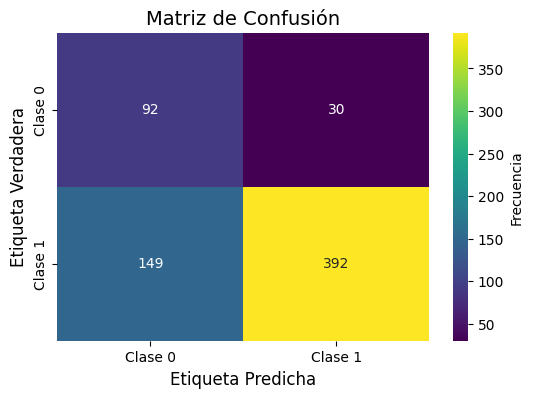

In [52]:
# Llama a la función con la ruta al archivo CSV
results_df = evaluate_with_entropy_thresholds(file_path)

### Mejor modelo

Accuracy: 0.8688
Precision: 0.8874
Recall: 0.9612
F1-score: 0.9228
F1-weighted-score: 0.8566

 



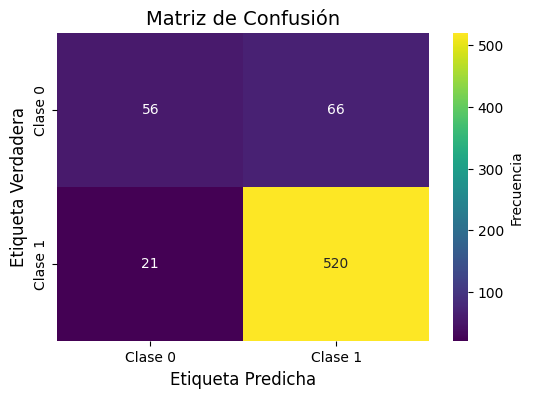

In [53]:
# Ejecutar la evaluación del modelo
evaluate_model(file_path, n= 3, skip= 2, remove_punctuation= False, remove_stopwords= False, lemmatize= False, use_entropy= True, apply_weighting= True, entropy_threshold=0.3)